In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v009.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks


In [2]:
import sys, os
import numpy as np
import xarray as xr
import skimage
import torch
import matplotlib.pyplot as plt
nax = np.newaxis

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

/ocean/projects/asc170022p/mtragoza/.conda/envs/MRE-PINN2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using backend: pytorch

Loading /ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks/../mre_pinn/__init__.py


True

# FEM box simulation ground truth

(320, 400)


<IPython.core.display.Javascript object>


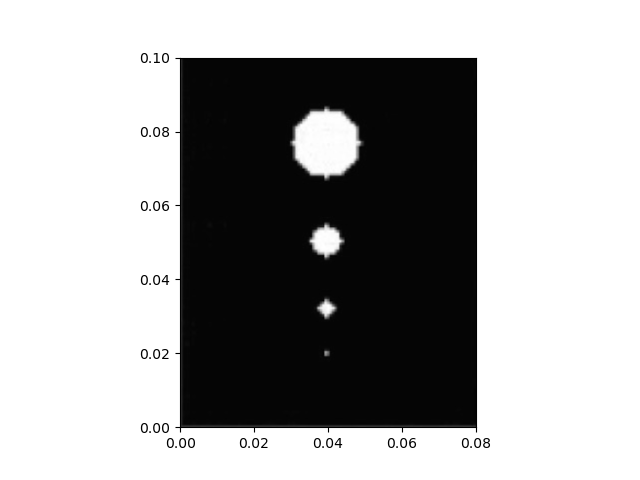

In [7]:
# read in the image file taken from the research article
im = skimage.io.imread('../data/BIOQIC/fem_box_ground_truth.png')
im = 1 - skimage.color.rgb2gray(im[...,:-1]) # drop alpha channel
im = skimage.transform.resize(im, (4*80, 4*100), anti_aliasing=True)
im = (im - im.min()) / (im.max() - im.min()) # scale values to [0, 1]
print(im.shape)

def imshow(ax, a, resolution, **kwargs):
    if a.ndim == 2:
        n_x, n_y = a.shape
        a_T = a.T
    elif a.ndim == 3:
        n_x, n_y, n_c = a.shape
        a_T = np.transpose(a, (1, 0, 2))
    extent = (0, n_x * resolution, 0, n_y * resolution)
    plt.imshow(a_T, origin='lower', extent=extent, **kwargs)

dx = 1e-3/4
fig, ax = plt.subplots()
imshow(ax, im, dx, cmap='gray')

In [8]:
# get the grid coordinates of the image
x = mre_pinn.data.nd_coords_from_shape(im.shape, resolution=0.25)
y_true = im.reshape(-1)
x.shape, y_true.shape

((128000, 2), (128000,))

In [68]:
import torch

def disk(x, center, radius, power):
    dist = torch.norm(x - center, dim=1)
    return torch.exp(-(dist / radius)**(power * radius))

def forward(x, centers, radii=[10, 5, 2, 1], power=2, background=3, target=9):
    y_pred = 0
    for c, r in zip(centers, radii):
        y_pred += disk(x, center=c[nax,:], radius=r, power=power)
    return y_pred

centers = torch.tensor([
    [39.25, 76.80],
    [39.30, 50.15],
    [39.25, 32.15],
    [39.25, 20.00],
], device='cuda')
print(centers)

# fit the centers to the image
x = torch.tensor(x, device='cuda')
im_true = torch.tensor(im, device='cuda')
centers = torch.nn.Parameter(centers + torch.normal(0, 1e-9, centers.shape))
optimizer = torch.optim.Adam([centers], lr=1e-3)

def closure():
    optimizer.zero_grad()
    y_pred = forward(x, centers)
    im_pred = y_pred.reshape(im_true.shape)
    loss = torch.mean(torch.abs(im_true - im_pred))
    loss.backward()
    return loss

max_iter = 1000
for i in range(max_iter):
    loss = optimizer.step(closure)
    if (i+1)%100 == 0:
        print(f'{i+1} {loss:.8f}')
        
print(centers)

y_pred = forward(x, centers)
im_pred = y_pred.reshape(im.shape).detach().cpu().numpy()
im_pred.sum()

tensor([[39.2500, 76.8000],
        [39.3000, 50.1500],
        [39.2500, 32.1500],
        [39.2500, 20.0000]])
100 0.02970059


/tmp/ipykernel_96591/695460044.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device='cuda')


200 0.02964605
300 0.02962993
400 0.02962733
500 0.02962720
600 0.02962719
700 0.02962719
800 0.02962719
900 0.02962719
1000 0.02962719
Parameter containing:
tensor([[39.3995, 76.6381],
        [39.3321, 50.2029],
        [39.5269, 31.9054],
        [39.1528, 19.8222]], requires_grad=True)


6164.267392056844

<IPython.core.display.Javascript object>


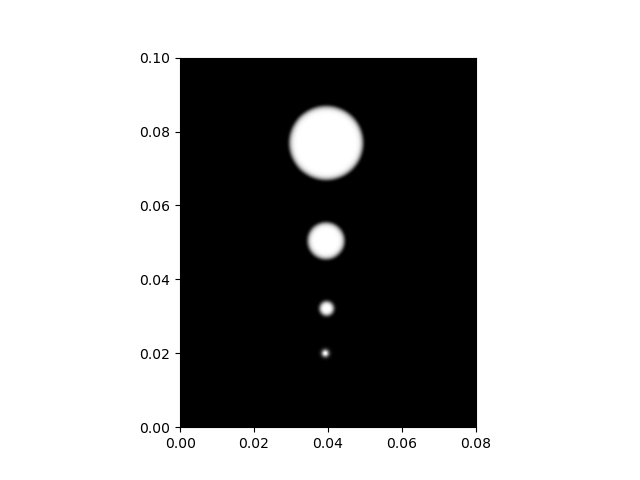

In [69]:
fig, ax = plt.subplots()
imshow(ax, im_pred, resolution=1e-3/4, cmap='gray')

<IPython.core.display.Javascript object>


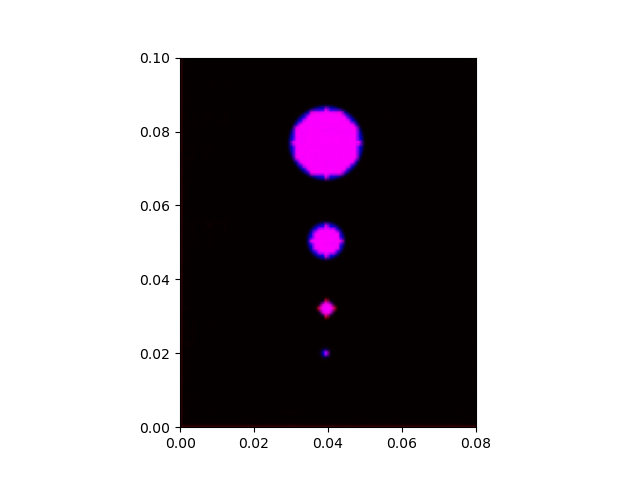

In [70]:
im_rgb = np.stack([im, np.zeros_like(im), im_pred], axis=-1)
fig, ax = plt.subplots()
imshow(ax, im_rgb, dx, vmin=0)

<IPython.core.display.Javascript object>


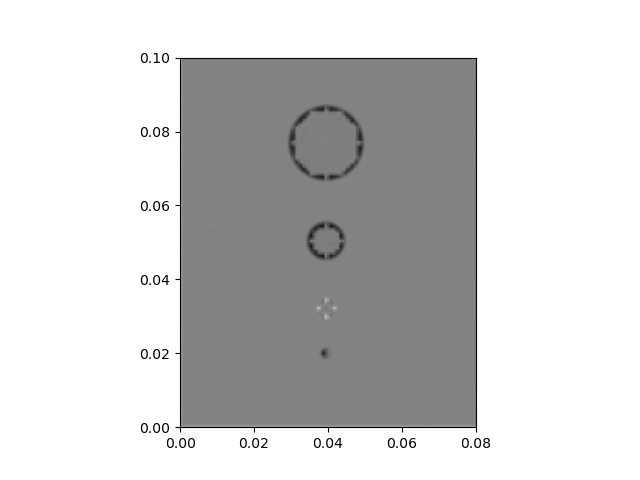

In [71]:
fig, ax = plt.subplots()
imshow(ax, im - im_pred, dx, cmap='gray', vmin=-1, vmax=1)

We are given the shear stiffness and viscosity of the background and target materials, which follow a Voigt model:

$$
    \sigma(t) = \mu \epsilon(t) + \eta \frac{\delta \epsilon}{\delta t}
$$

We can represent these values as a single complex-valued dynamic modulus:

$$
    G^\star(\omega) = \mu + i \omega \eta
$$

Which is composed of a storage and loss modulus (real and imaginary parts):

$$
\begin{align}
    G^\star(\omega) &= G'(\omega) + G''(\omega) \\
    G'(\omega) &= \mu \\
    G''(\omega) &= \omega \eta
\end{align}
$$

[ 50  60  70  80  90 100]
(320, 400) (6,)
(6, 10, 320, 400)
2 2


<IPython.core.display.Javascript object>


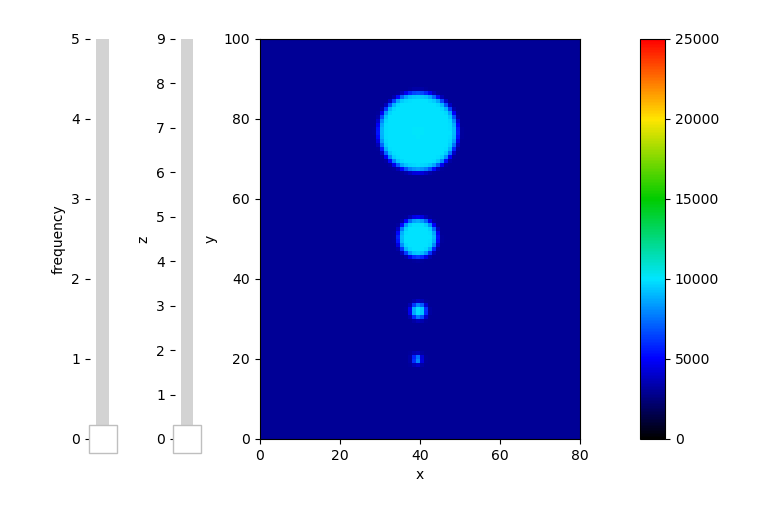

2 2


<IPython.core.display.Javascript object>


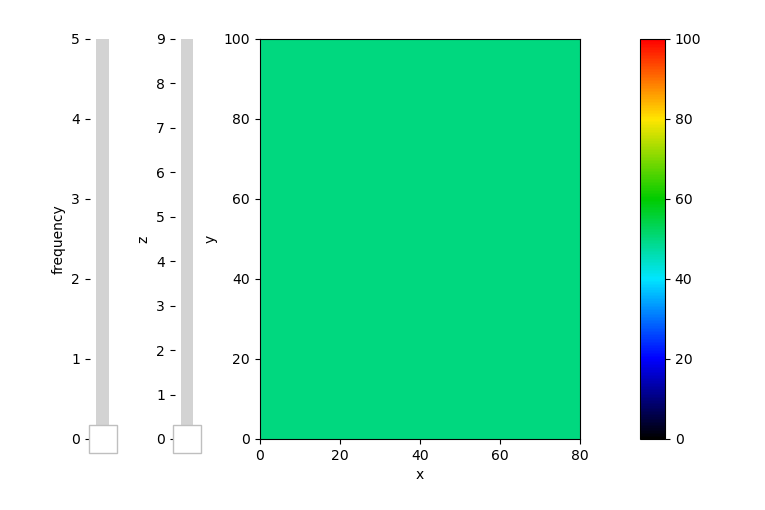

In [75]:
e_map = mre_pinn.visual.elast_color_map()

mu_bg = 3e3 # Pa
mu_target = 10e3 # Pa
nu = 1 # Pa·s
omega = np.arange(50, 101, 10)
print(omega)

G_real = mu_bg + im_pred * (mu_target - mu_bg)
G_imag = 2 * np.pi * omega * nu
print(G_real.shape, G_imag.shape)

G = G_real[nax,nax,...] + 1j * G_imag[:,nax,nax,nax]
G = np.repeat(G, 10, axis=1) # repeat along z axis
print(G.shape)

# downsample xy by 4
G = skimage.measure.block_reduce(G, block_size=(1, 1, 4, 4), func=np.mean)

labels = ['frequency', 'z', 'x', 'y']
mre_pinn.visual.NDArrayViewer(G.real, labels=labels, cmap=e_map, vmin=0, vmax=25e3, dpi=25)
mre_pinn.visual.NDArrayViewer(G.imag / (2*np.pi), labels=labels, cmap=e_map, vmin=0, vmax=100, dpi=25)

In [76]:
np.save('../data/BIOQIC/fem_box_ground_truth.npy', G)